# Neural Network Classifier x Toxic Content Detection
Il presente Notebook mostra l'addestramento ed il testing di un Classificatore basato su Neural network per il task di Toxic Content Detection.

I dati sono stati processati come segue:
1. Pulizia del testo (si veda, 'dataset_preprocessing.py')
2. Lemmatizzazione con NLTK
3. Vettorizzazione con TF-IDF

In [1]:
import pandas as pd
import pickle
import nltk
import re
import matplotlib.pyplot as plt
import numpy as np
from nltk.tokenize import word_tokenize
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv1D, MaxPooling1D, Flatten, Dense,Reshape
from tensorflow.keras.optimizers.legacy import Adam as Adam_legacy
from datetime import datetime
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay

C:\Users\Riccardo De Cesaris\AppData\Local\Temp\ipykernel_24304\2017852653.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


All'interno del Notebook saranno addestrate due Reti Neurali, una sul Dataset "non-Lemmatizzato" e l'altra sul Dataset "Lemmatizzato".

In [2]:
# Verifica il dispositivo attualmente utilizzato da TensorFlow
device_name = tf.test.gpu_device_name()

if device_name == '/device:GPU:0':
    print('GPU disponibile, TensorFlow sta utilizzando la GPU.')
else:
    print('GPU non disponibile, TensorFlow sta utilizzando la CPU.')

GPU disponibile, TensorFlow sta utilizzando la GPU.


## Funzioni di Supporto

In [3]:
# Pulizia della Frase
def clean_phrases(phrases):
    new_phrases = list()
    for phrase in phrases:
        # Rimozione di "\r" e "\n"
        phrase = re.sub(r'[\r\n]+', '', phrase)
        # Rimozione di sequenze di ":" (esempio, "::::")
        phrase = re.sub(r'::+', '', phrase)
        # Rimozione di sequenze di "=" (esempio, "====")
        phrase = re.sub(r'==+', '', phrase)
        # Rimozione di sequenze di "*" (esempio, "**")
        phrase = re.sub(r'\*\*+', '', phrase)
        # Rimozione di sequenze numeriche in formato di indirizzi IP (esempio, "192.168.1.1")
        phrase = re.sub(r'\b(?:\d{1,3}\.){3}\d{1,3}\b', '', phrase)
        # Rimozione di contenuto compreso tra Parentesi Quadre (esempio, "[contentContent]")
        phrase = re.sub(r'\[[^\[\]]+\]', '', phrase)
        # Rimozione di Apici, sia singoli che doppi
        phrase = re.sub(r"['\"]", "", phrase)

        ## La rimozione di particolari caratteri o sequenze di caratteri può portare alla fusione di due token diversi

        # Splitting di token in cui compare un segno di interpuzione forte ("?", "!" e ".") seguito da una lettera maiuscola
        phrase = re.sub(r'([?!\.])([A-Z]\w*)', r'\1 \2', phrase)
        # Splitting di parole fuse (esempio, "parolaParola" diventa "parola Parola")
        phrase = re.sub(r'([a-z])([A-Z])', r'\1 \2', phrase)

        tokens = word_tokenize(phrase)
        lowercase_tokens = [token.lower() for token in tokens if token.isalpha()]
        new_phrases.append(' '.join(lowercase_tokens))
    
    return new_phrases

In [4]:
# Lemmatizzazione della Frase
def get_wordnet_pos(tag):
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

def lemmatize_text(text):
    lemmatizer = WordNetLemmatizer()
    tokens = word_tokenize(text)
    tagged_tokens = nltk.pos_tag(tokens)
    lemmatized_text = []
    for token, tag in tagged_tokens:
        pos = get_wordnet_pos(tag)
        lemmatized_token = lemmatizer.lemmatize(token, pos=pos)
        lemmatized_text.append(lemmatized_token)
    return ' '.join(lemmatized_text)

# Neural Network, Dataset "non-Lemmatizzato"

## Addestramento

In [5]:
training_set = pd.read_csv("./../../datasets/training_set.csv")
print("Numero di Frasi nel Training Set:", len(training_set))
print("Numero Frasi 'toxic' nel Training Set:", len(training_set[training_set['toxic'] == 1]))
print("Numero Frasi 'not-toxic' nel Training Set:", len(training_set[training_set['toxic'] == 0]))

Numero di Frasi nel Training Set: 15282
Numero Frasi 'toxic' nel Training Set: 3058
Numero Frasi 'not-toxic' nel Training Set: 12224


In [6]:
y_train = training_set['toxic']

In [7]:
# Vettorizzazione con TF-IDF
vectorizer = TfidfVectorizer(dtype=np.float32)

X_train = vectorizer.fit_transform(training_set['comment_text'])
print("X_train.shape: " + str(X_train.shape))

X_train.shape: (15282, 39767)


In [8]:
model = tf.keras.models.Sequential(
    [
        tf.keras.layers.Input(shape=(X_train.shape[1],), dtype='float'),
        tf.keras.layers.Reshape((X_train.shape[1],1)),
        tf.keras.layers.Conv1D(filters=32, kernel_size=5, strides=2, padding='same', activation='relu'),
        tf.keras.layers.MaxPool1D(pool_size=2, padding='same'),
        tf.keras.layers.Conv1D(filters=32, kernel_size=3, padding='same', activation='relu'),
        tf.keras.layers.MaxPool1D(pool_size=2, padding='same'),
        tf.keras.layers.Conv1D(filters=16, kernel_size=5, padding='same', activation='relu'),
        tf.keras.layers.Conv1D(filters=8, kernel_size=5, padding='same', activation='relu'),
        tf.keras.layers.Conv1D(filters=4, kernel_size=5, padding='same', activation='relu'),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(140, activation='relu'),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(12, activation='relu'),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(1,activation='sigmoid')
    ]
)

In [9]:
model.summary()
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape (Reshape)           (None, 39767, 1)          0         
                                                                 
 conv1d (Conv1D)             (None, 19884, 32)         192       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 9942, 32)         0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 9942, 32)          3104      
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 4971, 32)         0         
 1D)                                                             
                                                                 
 conv1d_2 (Conv1D)           (None, 4971, 16)          2

In [10]:
X_train = X_train.toarray()

# Addestramento sul Dataset non-lemmatizzato
print("Training della Rete Neurale sul Dataset 'non-Lemmatizzato'...")
start = datetime.now()
model.fit(X_train, y_train,epochs=10, batch_size=32)
end = datetime.now()
print("Training completato! Tempo impiegato: " + str(end-start))

model.save("neural_classifier_big.h5")

Training della Rete Neurale sul Dataset 'non-Lemmatizzato'...
Epoch 1/10
478/478 [==============================] - 20s 27ms/step - loss: 0.3830 - accuracy: 0.8484
Epoch 2/10
478/478 [==============================] - 13s 27ms/step - loss: 0.2218 - accuracy: 0.9180
Epoch 3/10
478/478 [==============================] - 13s 27ms/step - loss: 0.1451 - accuracy: 0.9434
Epoch 4/10
478/478 [==============================] - 13s 27ms/step - loss: 0.1041 - accuracy: 0.9596
Epoch 5/10
478/478 [==============================] - 13s 27ms/step - loss: 0.0694 - accuracy: 0.9700
Epoch 6/10
478/478 [==============================] - 13s 27ms/step - loss: 0.0560 - accuracy: 0.9755
Epoch 7/10
478/478 [==============================] - 13s 27ms/step - loss: 0.0399 - accuracy: 0.9822
Epoch 8/10
478/478 [==============================] - 13s 27ms/step - loss: 0.0461 - accuracy: 0.9854
Epoch 9/10
478/478 [==============================] - 13s 27ms/step - loss: 0.0308 - accuracy: 0.9912
Epoch 10/10
478/478 

In [11]:
model = tf.keras.models.load_model("neural_classifier_big.h5")

## Testing

In [12]:
test_data = pd.read_csv("./../../datasets/test_set.csv")
test_data.dropna(inplace=True)

test_set = test_data[test_data['toxic'] != -1]
exp_set = test_data[test_data['toxic'] == -1]

print("Numero di Frasi nel Test Set:", len(test_set))
print("Numero Frasi 'toxic' nel Test Set:", len(test_set[test_set['toxic'] == 1]))
print("Numero Frasi 'not-toxic' nel Test Set:", len(test_set[test_set['toxic'] == 0]))

Numero di Frasi nel Test Set: 63842
Numero Frasi 'toxic' nel Test Set: 6087
Numero Frasi 'not-toxic' nel Test Set: 57755


In [13]:
y_test = test_set['toxic']

In [14]:
X_test = vectorizer.transform(test_set['comment_text'])
print("X_test.shape: " + str(X_test.shape))

X_test.shape: (63842, 39767)


In [15]:
i = 0
predictions = list()
while i < X_test.shape[0]:
    to_submit = X_test[i:i+2500]
    to_test = to_submit.toarray()
    y_pred = model.predict(to_test)
    predictions.append(y_pred)
    i += 2500

    del to_submit
    del to_test
    del y_pred

42/42 [==============================] - 0s 10ms/step


In [16]:
y_pred = np.concatenate(predictions)
y_pred.shape
y_pred_binary = np.where(y_pred > 0.5, 1, 0)

In [17]:
#Metriche: Accuracy,Precision,Recall
print("Accuracy: " + str(accuracy_score(y_test, y_pred_binary)))
print("Precision: " + str(precision_score(y_test, y_pred_binary)))
print("Recall: " + str(recall_score(y_test, y_pred_binary)))
print("F-Measure: " + str(f1_score(y_test, y_pred_binary)))

Accuracy: 0.8966041164123931
Precision: 0.4748778103616813
Recall: 0.7980942993264334
F-Measure: 0.5954525954525954


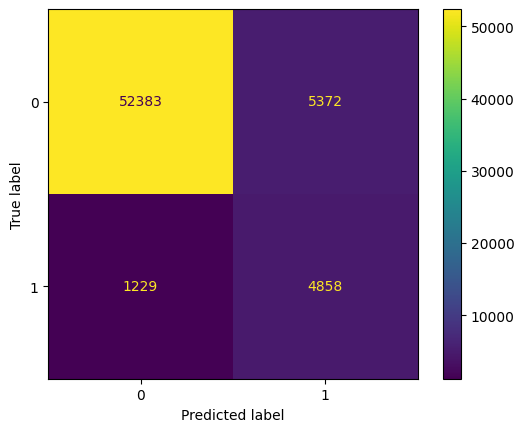

In [18]:
cm = confusion_matrix(y_test, y_pred_binary, labels=[0,1])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0,1])
disp.plot()
plt.show()

## Generazione delle Explanations

In [19]:
# Utilizzare exp_set -> da vettorizzare con 'vectorizer' e sottoporre a 'cl'
# Implementare LIME

# Neural Network, Dataset "Lemmatizzato"

In [30]:
tf.keras.backend.clear_session()

## Addestramento

In [21]:
training_set_lem = pd.read_csv("./../../datasets/training_set_lemmatized.csv")

In [22]:
# Vettorizzazione con TF-IDF
vectorizer_lem = TfidfVectorizer(dtype=np.float32)

X_train_lem = vectorizer_lem.fit_transform(training_set_lem['comment_text'])
print("X_train_lem.shape: " + str(X_train_lem.shape))

X_train_lem.shape: (15282, 34238)


In [23]:
model_lem = tf.keras.models.Sequential(
    [
        tf.keras.layers.Input(shape=(X_train_lem.shape[1],), dtype='float'),
        tf.keras.layers.Reshape((X_train_lem.shape[1],1)),
        tf.keras.layers.Conv1D(filters=32, kernel_size=5, strides=2, padding='same', activation='relu'),
        tf.keras.layers.MaxPool1D(pool_size=2, padding='same'),
        tf.keras.layers.Conv1D(filters=32, kernel_size=3, padding='same', activation='relu'),
        tf.keras.layers.MaxPool1D(pool_size=2, padding='same'),
        tf.keras.layers.Conv1D(filters=16, kernel_size=5, padding='same', activation='relu'),
        tf.keras.layers.Conv1D(filters=8, kernel_size=5, padding='same', activation='relu'),
        tf.keras.layers.Conv1D(filters=4, kernel_size=5, padding='same', activation='relu'),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(140, activation='relu'),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(12, activation='relu'),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(1,activation='sigmoid')
    ]
)

In [24]:
model_lem.summary()
model_lem.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape (Reshape)           (None, 34238, 1)          0         
                                                                 
 conv1d (Conv1D)             (None, 17119, 32)         192       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 8560, 32)         0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 8560, 32)          3104      
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 4280, 32)         0         
 1D)                                                             
                                                                 
 conv1d_2 (Conv1D)           (None, 4280, 16)          2

In [25]:
X_train_lem = X_train_lem.toarray()

# Addestramento sul Dataset non-lemmatizzato
print("Training della Rete Neurale sul Dataset 'non-Lemmatizzato'...")
start = datetime.now()
model_lem.fit(X_train_lem, y_train,epochs=10, batch_size=32)
end = datetime.now()
print("Training completato! Tempo impiegato: " + str(end-start))

model_lem.save("neural_classifier_big_lem.h5")

Training della Rete Neurale sul Dataset 'non-Lemmatizzato'...
Epoch 1/10
478/478 [==============================] - 12s 23ms/step - loss: 0.3902 - accuracy: 0.8473
Epoch 2/10
478/478 [==============================] - 11s 23ms/step - loss: 0.2338 - accuracy: 0.9119
Epoch 3/10
478/478 [==============================] - 11s 23ms/step - loss: 0.1611 - accuracy: 0.9437
Epoch 4/10
478/478 [==============================] - 11s 23ms/step - loss: 0.1221 - accuracy: 0.9570
Epoch 5/10
478/478 [==============================] - 11s 23ms/step - loss: 0.0891 - accuracy: 0.9686
Epoch 6/10
478/478 [==============================] - 11s 22ms/step - loss: 0.0667 - accuracy: 0.9764
Epoch 7/10
478/478 [==============================] - 11s 22ms/step - loss: 0.0503 - accuracy: 0.9823
Epoch 8/10
478/478 [==============================] - 11s 22ms/step - loss: 0.0422 - accuracy: 0.9830
Epoch 9/10
478/478 [==============================] - 11s 22ms/step - loss: 0.0373 - accuracy: 0.9855
Epoch 10/10
478/478 

In [31]:
model_lem = tf.keras.models.load_model("neural_classifier_big_lem.h5")

## Testing

In [32]:
test_data_lem = pd.read_csv("./../../datasets/test_set_lemmatized.csv")
test_data_lem.dropna(inplace=True)

test_set_lem = test_data_lem[test_data_lem['toxic'] != -1]
exp_set_lem = test_data_lem[test_data_lem['toxic'] == -1]

In [33]:
X_test_lem = vectorizer_lem.transform(test_set_lem['comment_text'])
print("X_test_lem.shape: " + str(X_test_lem.shape))

X_test_lem.shape: (63842, 34238)


In [34]:
i = 0
predictions = list()
while i < X_test.shape[0]:
    to_submit = X_test_lem[i:i+2500]
    to_test = to_submit.toarray()
    y_pred = model_lem.predict(to_test)
    predictions.append(y_pred)
    i += 2500

    del to_submit
    del to_test
    del y_pred

42/42 [==============================] - 0s 9ms/step


In [35]:
y_pred_lem = np.concatenate(predictions)
y_pred_lem.shape
y_pred_binary_lem = np.where(y_pred_lem > 0.5, 1, 0)

In [36]:
#Metriche: Accuracy,Precision,Recall
print("Accuracy: " + str(accuracy_score(y_test, y_pred_binary_lem)))
print("Precision: " + str(precision_score(y_test, y_pred_binary_lem)))
print("Recall: " + str(recall_score(y_test, y_pred_binary_lem)))
print("F-Measure: " + str(f1_score(y_test, y_pred_binary_lem)))

Accuracy: 0.885655211302904
Precision: 0.4460553233122832
Recall: 0.8238869722359126
F-Measure: 0.5787651471436814


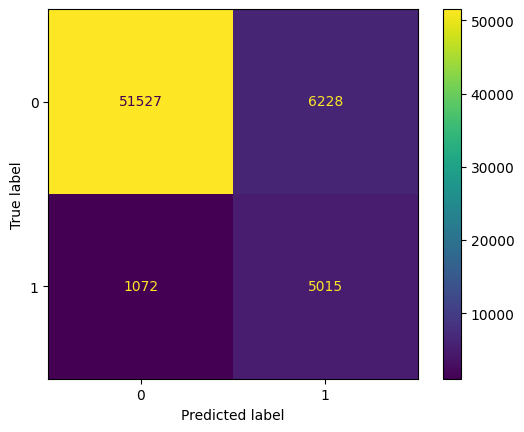

In [37]:
cm = confusion_matrix(y_test, y_pred_binary_lem, labels=[0,1])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0,1])
disp.plot()
plt.show()

## Generazione delle Explanations

In [38]:
# Utilizzare exp_set -> da vettorizzare con 'vectorizer' e sottoporre a 'cl'
# Implementare LIME